In [1]:
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/item_matching/')

In [3]:
col_names = ['ITEM_NUM','DESCRIPTION']

In [4]:
chunksize=24000

In [5]:
CLAS_PATH=Path('data/item_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/item_lm/')
LM_PATH.mkdir(exist_ok=True)

In [6]:
df_trn = pd.read_csv(PATH/'items_train.csv', sep='|', index_col=False,header=None, chunksize=chunksize,engine='python')
df_val = pd.read_csv(PATH/'items_validation.csv', sep='|', index_col=False,header=None, chunksize=chunksize,engine='python')

In [7]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('&', ' ')
#   x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
#         'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
#         '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
#         ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [8]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.str)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [9]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [10]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [11]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [12]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [13]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [14]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('t_up', 194836),
 (',', 76078),
 ('1', 58104),
 ('\n', 54995),
 ('xbos', 54995),
 ('xfld', 54995),
 ('/', 9254),
 ('"', 7742),
 ('-', 3071),
 ('oz', 2157),
 ('2', 1808),
 ('.', 1726),
 ('3', 1722),
 ('white', 1668),
 ('4', 1609),
 ('8', 1445),
 ('cheese', 1414),
 ('black', 1203),
 ('beef', 1182),
 ('#', 1149),
 ('w', 1075),
 ('5', 1072),
 ('chicken', 1030),
 ('plastic', 941),
 ('6', 927)]

In [15]:
max_vocab = 60000
min_freq = 2

In [16]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [17]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7968

In [18]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [19]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [20]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [21]:
vs=len(itos)
vs,len(trn_lm)

(7968, 54995)

In [22]:
em_sz,nh,nl = 400,1150,3

In [23]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [24]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [25]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [26]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [27]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [28]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [29]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [30]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [31]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [32]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [33]:
learner.model.load_state_dict(wgts)

In [34]:
lr=1e-3
lrs = lr

In [35]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.041253   3.630344   0.477393  



[array([3.63034]), 0.47739292640943787]

In [36]:
learner.save('lm_last_ft')

In [37]:
learner.load('lm_last_ft')

In [38]:
learner.unfreeze()

In [39]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      2.374467   2.204106   0.62497   



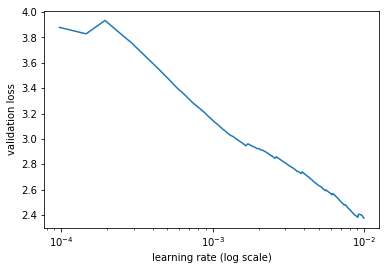

In [44]:
learner.sched.plot(n_skip=2,n_skip_end=0)

In [47]:
learner.fit(0.01, 1, wds=wd, use_clr=(20,10), cycle_len=5)

epoch      trn_loss   val_loss   accuracy                   
    0      3.556543   3.620383   0.513889  
    1      3.111399   3.063194   0.564345                   
    2      3.058429   2.922973   0.582904                   
    3      2.983958   2.878005   0.591392                   
    4      2.937262   2.807806   0.599579                   


[array([2.80781]), 0.5995793197606061]

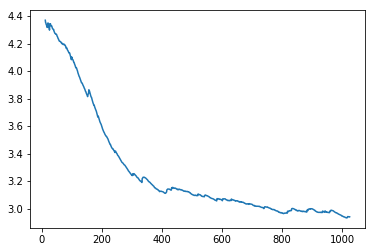

In [72]:
learner.save('lm1')
learner.save_encoder('lm1_enc')
learner.sched.plot_loss()

## Classifier 

In [48]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [84]:
trn_labels

array(['AM345140', 'XFH2778536', 'XFH2778538', ..., 'XFB2654986', 'XFB1706507', 'XFB851302'], dtype='<U15')

In [85]:
val_labels

array(['XFB107223', 'XFB106013', 'XFB2452072', ..., 'XFB985518', 'XFB985380', 'XFB985383'], dtype='<U14')

In [50]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [51]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [52]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

7968

In [53]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [54]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

In [55]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [56]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [63]:
trn_labels.size

54995

In [59]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [60]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [61]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [65]:
c=54996 #total labels

In [66]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [67]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [68]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [77]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [78]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [79]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [80]:
learn.freeze_to(-1)

In [81]:
learn.lr_find(lrs/1000)
learn.sched.plot()

  0%|          | 0/2292 [00:00<?, ?it/s]

NotImplementedError: <U11

In [83]:
learn.fit(0.01, 1, wds=wd, cycle_len=1, use_clr=(8,3))

  0%|          | 0/2292 [00:00<?, ?it/s]

NotImplementedError: <U13